# Drawing image stripes to visualize golden ratio–based sampling

Sampling the unit with golden ratio steps has interesting properties, such as putting each new sample in the largest gap between previous samples. For most people (me, for example), this is much easier to visualize than to try to understand purely as math.

In this notebook, we’ll sample bars out of an image in a way that illustrates how golden ratio sampling works in one dimension.

In [1]:
from skimage import io
import numpy as np

First we want an image that is in the public domain and has interesting linear structures.

In [2]:
original = io.imread(
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Nighthawks_by_Edward_Hopper_1942.jpg/1280px-Nighthawks_by_Edward_Hopper_1942.jpg"
)

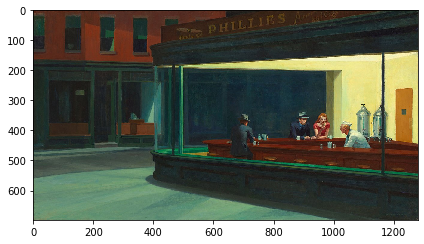

In [3]:
io.imshow(original)

We need a function to paint a given stripe from image A into image B. (It’s simpler to paint one stripe at a time, using B as a carry, instead of recreating the whole image on each call.) It will take these parameters:

- Source image: where pixels come from.
- Destination image: where pixels go to. This may already have pixels painted into it; again, the function only does one step of painting.
- What proportion of the way along the horizontal of the image to paint the stripe. We’ll call this `t`, which is traditionally used for “proportional arc length at which to interpolate” in some corners of graphics processing, in lerp functions and such.
- The width of the stripe, as a propotion of the width of the image.

We could add some kind of interpolation, say `skimage.restoration.inpaint_biharmonic`, but let’s keep that out of the painter function. Most of the painter is just arithmetic to place the stripe edges.

In [4]:
def paint(src, dst, t, stripe_width):
    assert src.shape == dst.shape
    image_width = src.shape[1]
    
    # convert stripe_width to pixels
    stripe_width = int(image_width * stripe_width)

    # Since the stripe has width, we might reasonable say that t indexes only
    # the span where a stripe could be fully drawn (so that a stripe drawn at
    # t=0 just brished the left edge of the image, for example). I did it this 
    # way in the slides Eric showed at NACIS. But today I feel like allowing 
    # partial stripes.
    stripe_center = int(t * image_width)
    left_margin = stripe_width//2
    right_margin = stripe_width - left_margin

    left_stripe_side = max(0, stripe_center - left_margin)
    right_stripe_side = min(image_width, stripe_center + right_margin)

    dst[:, left_stripe_side:right_stripe_side] = src[:, left_stripe_side:right_stripe_side]
    return dst

In [5]:
phi = (1 + 5**0.5) / 2  # https://knowyourmeme.com/memes/pointing-rick-dalton

stripey = np.zeros_like(original)

for n in range(1):
    t = (0.5 + phi * n) % 1
    # the 0.5 is just because starting in the center is a nice convention

    stripey = paint(original, stripey, t, 1/40)

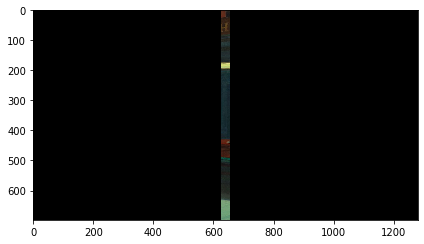

In [6]:
io.imshow(stripey)

Looks like it should! Since it’ll just paint on top of the old pixels, we can start the `n` counter over.

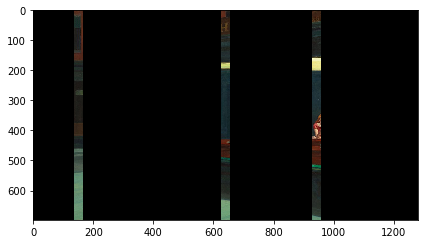

In [7]:
for n in range(3):
    t = (0.5 + phi * n) % 1
    stripey = paint(original, stripey, t, 1/40)

io.imshow(stripey)

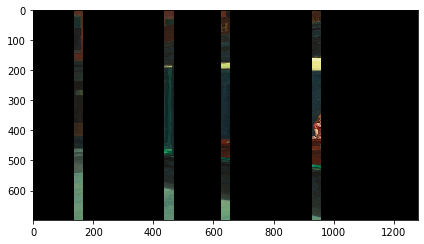

In [8]:
for n in range(4):
    t = (0.5 + phi * n) % 1
    stripey = paint(original, stripey, t, 1/40)

io.imshow(stripey)

What if we want to waterfall these, to see the inpainting over the process without having to animate? But instead of a waterfall, let’s call this a skyline; you’ll see why in a moment.

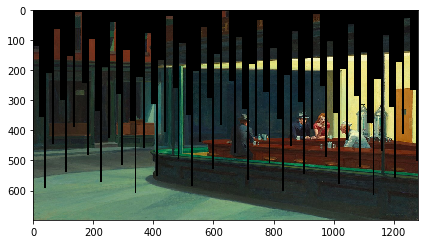

In [9]:
def skyline(img, steps, stripe_width):
    waterfall = np.zeros_like(img)
    stripey = waterfall.copy()

    height = img.shape[0]
    slice_height = height/steps

    for n in range(steps):
        t = (0.5 + phi * n) % 1
        stripey = paint(img, stripey, t, stripe_width)
        slice_top = int(slice_height * n)
        slice_bottom = int(slice_height * (n+1))
        waterfall[slice_top:slice_bottom] = stripey[slice_top:slice_bottom]

    return waterfall

io.imshow(skyline(original, 100, 1/60))

Clearly, _Nighthawks_ is pretty much exactly the wrong image for this, because the dark top edge hides things. We could change the background color to something other than black, for example, but let’s just try other image. Also, I admit `skimage.io.imshow` is sort of terrible for this; if you want to see bigger versions, `io.imsave()` to a separate file or switch to `matplotlib` or whatever.

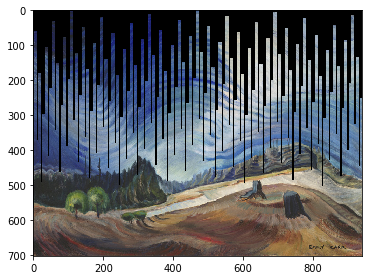

In [10]:
io.imshow(
    skyline(
        io.imread(
            "https://upload.wikimedia.org/wikipedia/commons/1/14/Above_the_Gravel_Pit_by_Emily_Carr%2C_1937%2C_oil_on_canvas.jpg"
        ),
        200,
        1/100,
    )
)

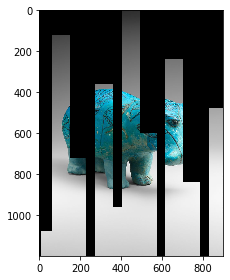

In [11]:
io.imshow(
    skyline(
        io.imread(
            "https://collectionapi.metmuseum.org/api/collection/v1/iiif/544227/1216904/main-image"
        ),
        10,
        1/10,
    )
)

𝓕𝓲𝓷